# A/B-тест гипотез для увеличения выручки

**Цель проекта** - протестировать гипотезы для увеличения выручки интернет-магазина, составленные совместно с отделом маркетинга. 

## План выполнения работы:

1. [**Предобработка данных**](#processing) 
2. [**Приоритизация гипотез**](#prioritisation)
3. [Фреймворк ICE](#ICE)
4. [Фреймворк RICE](#RICE)
5. [Как изменилась приоритизация гипотез при применении RICE](#difference)
6. [**Анализ A/B-теста**](#AB)
7. [График кумулятивной выручки по группам](#revenue)
8. [График кумулятивного среднего чека по группам](#bill)
9. [График относительного изменения кумулятивного среднего чека группы B к группе A](#differencebill) 
10. [График кумулятивной конверсии по группам](#conversion)
11. [График относительного изменения кумулятивной конверсии группы B к группе A](#differenceconversion) 
12. [Точечный график количества заказов по пользователям](#orders)
13. [95-й и 99-й перцентили количества заказов на пользователя](#percentiles1)
14. [Точечный график стоимостей заказов](#ordersbill)
15. [95-й и 99-й перцентили стоимости заказов](#percentiles2)
16. [Значимость различий в конверсии между группами по «сырым» данным](#raw1)
17. [Значимость различий в среднем чеке заказа между группами по «сырым» данным](#raw2)
18. [Значимость различий в конверсии между группами по «очищенным» данным](#clean1)
19. [Значимость различий в среднем чеке заказа между группами по «очищенным» данным](#clean2)
20. [**Вывод**](#conclusion)

### Импорт бибилиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import datetime as dt
import scipy.stats as stats

### Импорт и вывод данных

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
print('Гипотезы')
display(hypothesis.head())
print('-----------------------------------')
print('Заказы')
display(orders.head())
print('-----------------------------------')
print('Группы пользователей А/В теста')
display(visitors.head())

Гипотезы


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


-----------------------------------
Заказы


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


-----------------------------------
Группы пользователей А/В теста


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Открыли данные, убедились, что все на месте
## Описание данных

Для проведения A/B теста было использовано 3 файла: hypothesis, orders и visitors. 

**Файл hypothesis.csv**
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Файл orders.csv**

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

**Файл visitors.csv**

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Предобработка данных <a id="processing"></a>

In [4]:
print('Число заказов до исключения ошибочных записей',orders['visitorId'].count())
falls = orders.groupby(['visitorId']).agg({'group':'sum'})
falls = falls.query('group == "BA" or group == "AB"').reset_index()
orders = orders.merge(falls, on='visitorId', how='left')
orders = orders.fillna(999)
orders = orders.query('group_y == 999')
orders = orders[['transactionId', 'visitorId', 'date', 'revenue', 'group_x']]
orders.rename(columns={'group_x':'group'}, inplace=True)
print('Число заказов после исключения ошибочных записей',orders['visitorId'].count(), '. Размер выбросов составил 5.85%')
# Убрали тех пользователей с заказами, которые попали в обе группы А и В. Такого быть не должно.
print(hypothesis.info())
print(orders.info())
print(visitors.info())
orders['date'] = pd.to_datetime(orders['date'], format='%Y.%m.%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y.%m.%d')
hypothesis.rename(columns={'Hypothesis': 'hypothesis', 'Reach':'reach', 'Impact':'impact', 'Confidence':'confidence', 'Efforts':'efforts'}, inplace=True)

Число заказов до исключения ошибочных записей 1197
Число заказов после исключения ошибочных записей 1127 . Размер выбросов составил 5.85%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1127 non-null   int64 
 1   visitorId      1127 non-null   int64 
 2   date           1127 non-null   object
 3   revenue        1127 non-null   int64 
 4   group          1127 non-null   object
dtypes: int64(3

Оказалось, что имеются случаи, когда пользователи с заказами попадали одновременно и в группу А и в группу В. Такого быть не должно. В реальной жизни возникли бы вопросы к корректности проведения теста. Логично предложить перезапустить тест.
Но т.к. мы обязаны сделать этот проект, то разумно просто выкинуть данные результаты. Размер выборки, которую мы удалили составляет 5.85%

## Приоритизация гипотез <a id="prioritisation"></a>

### Фреймворк ICE <a id="ICE"></a>

In [5]:
hypothesis['ice_score']=round((hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']), 2)
hypothesis_ice =hypothesis[['hypothesis','ice_score']].sort_values(by='ice_score', ascending=False)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
display(hypothesis_ice)

,hypothesis,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Фреймворк RICE <a id="RICE"></a>

In [6]:
hypothesis['rice_score']=hypothesis['impact']*hypothesis['confidence']*hypothesis['reach']/hypothesis['efforts']
hypothesis_rice = hypothesis[['hypothesis','rice_score']].sort_values(by='rice_score', ascending=False)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
display(hypothesis_rice)

,hypothesis,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Как изменилась приоритизация гипотез при применении RICE вместо ICE <a id="difference"></a>

In [7]:
rice_vs_ice = hypothesis_rice.merge(hypothesis_ice, on='hypothesis')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
display(rice_vs_ice)

,hypothesis,rice_score,ice_score
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.20
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.00
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.33
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.00
4,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.20
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.12
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.00
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.33
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.00


Приоритизация изменилась в сторону большего охвата. 
* Метод ICE обладает следующими недостатками: одна и та же гипотеза может оцениваться по-разному одним и тем же лицом в разное время. Если разные люди оценивают гипотезы — все они будут оценивать ее по-разному.
* Метод RICE устранил данный недостаток, отдав предпочтение гипотезам, которые больше повлияют на показатели компании.
* **Для рассмотрения в первую очередь я бы предложила рассматривать те гипотезы, которые набрали значительное количество баллов и по RICE и по ICE, а именно гипотезы 0 и 2 (форма для сбора базы для email-рассылок + добавление двух новых канала привлечения трафика). После бы тестировала гипотезы в порядке убывания по RICE (1,3,4)**

## Анализ A/B-теста <a id="AB"></a>

### 1. График кумулятивной выручки по группам <a id="revenue"></a>

In [8]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

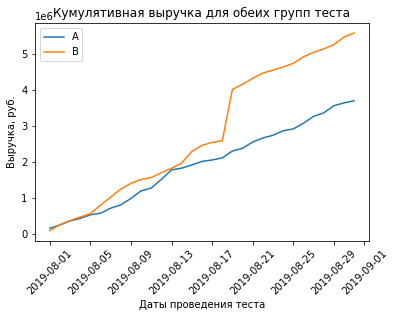

In [9]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

#print(cumulativeData.head(5))

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.xticks(rotation= 45)
plt.xlabel("Даты проведения теста")
plt.ylabel("Выручка, руб.")
plt.title('Кумулятивная выручка для обеих групп теста')
plt.show()

Группа В стабильно лучше по накопленным показателям, чем А. В начале теста были колебания конверсии в обеих группах. На графике заметен резкий взлет графика группы В. Это может быть связано с аномалиями, которые мы выкинем чуть позже. Также нельзя не заметить, что 13.08.2019 кумулятивная выручка у групп была одинаковая. Произошло это из-за небольшого увеличения выручки в группе А

### 2. График кумулятивного среднего чека по группам <a id="bill"></a>

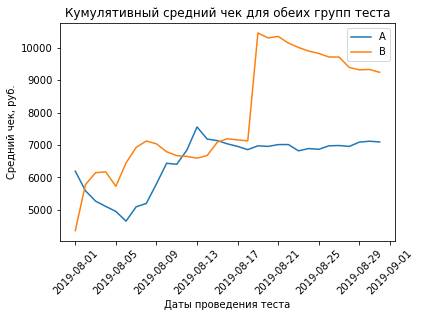

In [10]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation= 45)
plt.xlabel("Даты проведения теста")
plt.ylabel("Средний чек, руб.")
plt.title('Кумулятивный средний чек для обеих групп теста')
plt.show()

Средний чек группы В преобладает над средним чеком группы А на протяжении почти всего теста, кроме 2019-08-13. Возможно, в группу А в тот момент теста попали крупные заказы (резкий всплеск на графике). Тем не менее средний чек группы В явно доминирует над чеком группы А. Резкий скачок графика В после 17.08.2019 можно объяснить аномалиями. Если бы аномалий не было, график группы В под конец теста, вероятнее всего, был бы ниже графика А, т.к. к концу теста график В снижается, график А поднимается, а в точке наблюдения аномалии их графики находятся рядом друг с другом.

### 3. График относительного изменения кумулятивного среднего чека группы B к группе A <a id="differencebill"></a>

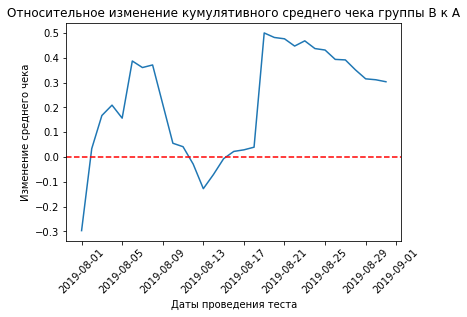

In [11]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--')
plt.xticks(rotation= 45)
plt.xlabel("Даты проведения теста")
plt.ylabel("Изменение среднего чека")
plt.title('Относительное изменение кумулятивного среднего чека группы B к A')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». В группе В где-то есть крупные заказы и выбросы. Далее мы найдем их. Тем не менее ближе к концу графика видно, что он стабилизировался с сохранением доминирования над группой А.



После рассмотрения вышеприведенных графиков можно сделать следующие выводы:
* На первый взгляд кажется, что группа В доминирует по показателям над группой А на всех графиках
* Нельзя не заметить аномалии, которые и привели к возрастаниям графиков группы В на всех графиках
* Также на всех графиках заметно, что при отсутствии аномалии группа В врядли бы была лучше группы А по показателям.

### 4. График кумулятивной конверсии по группам <a id="conversion"></a>

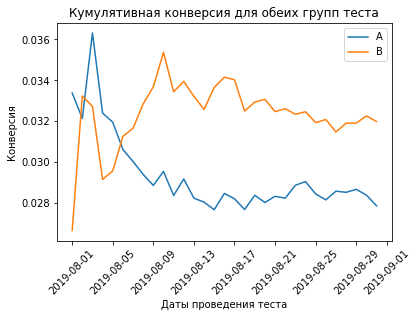

In [12]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel("Даты проведения теста")
plt.ylabel("Конверсия")
plt.title('Кумулятивная конверсия для обеих групп теста')

# задаем масштаб осей
#plt.axis(["2019-04-01", '2019-04-23', 0, 0.015])
plt.xticks(rotation= 45)
plt.show()

График получился асимметричным. Сначала группы симметрично колебались, но затем конверсия группы A резко просела, а конверсия группы B подскачила. Оба графика имеют сильные скачки, но тем не менее ближе к концу относительно друг друга они стабилизировались. Кумулятивная конверсия группы В очевидно превосходит группу А

### 5. График относительного изменения кумулятивной конверсии группы B к группе A <a id="differenceconversion"></a>

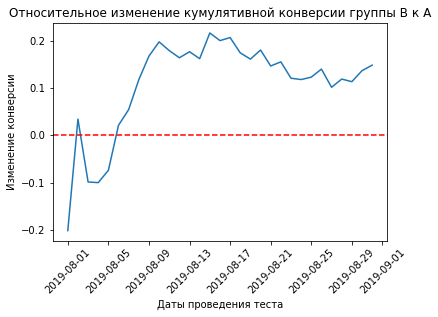

In [13]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label='Δ')
plt.title('Относительное изменение кумулятивной конверсии группы B к A')
plt.xlabel("Даты проведения теста")
plt.ylabel("Изменение конверсии")
plt.axhline(y=0, color='red', linestyle='--')
#plt.axis(["2019-04-01", '2019-04-23', -0.6, 0.6])
plt.xticks(rotation= 45)
plt.show()

В начале теста группа B проигрывала группе A, затем резко вырвалась вперёд. Потом её конверсия слегка падала, но оставаясь гораздо выше кум. конверсии группы А.
В целом отношение конверсии установилось, и уже сейчас можно сделать выводы: группа В превосходит группу А по показателям. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

### 6. Точечный график количества заказов по пользователям <a id="orders"></a>

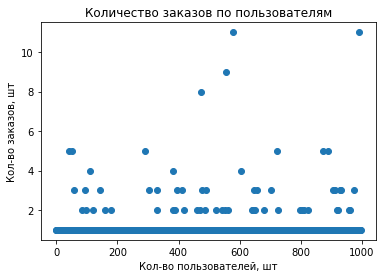

In [14]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['visitorsId','orders']
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

plt.title('Количество заказов по пользователям')
plt.xlabel("Кол-во пользователей, шт")
plt.ylabel("Кол-во заказов, шт")
plt.show()

Много пользователей с 2-3 заказами. Их точная доля пока не ясна.

### 7. 95-й и 99-й перцентили количества заказов на пользователя <a id="percentiles1"></a>

In [15]:
print(np.percentile(ordersByUsers['orders'], [95, 99]).round())

[2. 4.]


### 8. Точечный график стоимостей заказов <a id="ordersbill"></a>

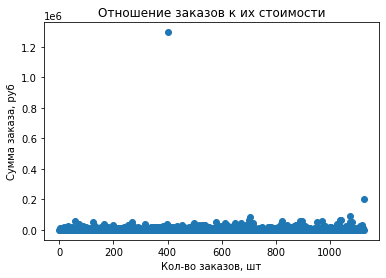

In [16]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Отношение заказов к их стоимости')
plt.xlabel("Кол-во заказов, шт")
plt.ylabel("Сумма заказа, руб")
plt.show()

Есть немного дорогих заказов. Судя по всему, именно они и были теми аномальными значениями, благодаря которым графики группы В резко поднимались вверх, создавая ложную картину доминирования. По графику можно выбрать границу аномальных заказов от 200000. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. 

### 9. 95-й и 99-й перцентили стоимости заказов <a id="percentiles2"></a>

In [17]:
print(np.percentile(orders['revenue'], [95, 99]).round())

[27460. 55936.]


Так как принято отсеивать 1-5% крайних значений, то границами для своего теста я возьму крайние значения 95%-ых персентилей, то есть для количества заказов эта граница будет в 2 заказа, а для стоимости - 27460 руб. 

### 10. Значимость различий в конверсии между группами по «сырым» данным <a id="raw1"></a>

Протестируем гипотезы на сырых данных. Формулировка гипотез будет звучать так: 

**Нулевая гипотеза:** Cтатистически значимых различий в конверсии по "сырым" данным между группами A и B нет.

**Обратная гипотеза:** Есть статистически значимые различия в конверсии по "сырым" данным между группами A и B.  

In [18]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,19,82717,24,148579,19,82717,719,713,719,713
1,2019-08-02,19,91602,24,165531,43,240181,43,248248,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,67,352654,59,362496,507,509,1845,1803
3,2019-08-04,16,70825,16,100170,83,423479,75,462666,717,770,2562,2573
4,2019-08-05,23,100878,22,92328,106,524357,97,554994,756,707,3318,3280


In [19]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.007
0.148


Первое число — p-value = 0.007 меньше 0.05. Значит, нулевую гипотезу "статистически значимых различий в конверсии между группами нет" отвергаем. Относительный выигрыш группы B равен 14.8%

**Вывод**: По «сырым» данным различия в конверсии групп A и B есть.

### 11. Значимость различий в среднем чеке заказа между группами по «сырым» данным <a id="raw2"></a>

Протестируем гипотезы на сырых данных. Формулировка гипотез будет звучать так: 

**Нулевая гипотеза:** Cтатистически значимых различий в размере среднего чека по "сырым" данным между группами A и B нет.

**Обратная гипотеза:** Есть статистически значимые различия в размере среднего чека по "сырым" данным между группами A и B.  

In [ ]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value значительно больше 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно больше среднего чека группы A.

### 12. Значимость различий в конверсии между группами по «очищенным» данным <a id="clean1"></a>

In [ ]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 27460]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

Аномальных пользователей: 72 

Протестируем гипотезы на очищенных данных. Формулировка гипотез будет звучать так: 

**Нулевая гипотеза:** Cтатистически значимых различий на очищенных данных в конверсии между группами A и B нет.

**Обратная гипотеза:** Есть статистически значимые различия на очищенных данных в конверсии между группами A и B.  

In [ ]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Результаты по конверсии практически не изменились

### 13. Значимость различий в среднем чеке заказа между группами по «очищенным» данным <a id="clean2"></a>

Протестируем гипотезы на сырых данных. Формулировка гипотез будет звучать так: 

**Нулевая гипотеза:** Cтатистически значимых различий в размере среднего чека на очищенных данных между группами A и B нет.

**Обратная гипотеза:** Есть статистически значимые различия в размере среднего чека на очищенных данных между группами A и B.  

In [ ]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

* Неочищенные данные: 0.339 и 0.303
* Чистые данные: 0.316 и -0.045
* P-value значительно больше 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B стал меньше среднего чека группы A после очистки от выбросов.

## Выводы <a id="conclusion"></a>

**Приоритизация гипотез**
* Проведя анализ по ICE и RICE увидели, что есть гипотезы, которые набрали больше всего баллов в обеих методах анализа - 0, 2. Это формы для сбора базы для email-рассылок + добавление двух новых канала привлечения трафика. Для первоочерёдного тестирования лучше всего выбрать их, а после тестировать гипотезы в порядке убывания по RICE (1,3,4)

**Анализ данных** 
* По кумулятивным метрикам группа B преобладает над A и по величине выручки и по среднему чеку. Однако в группе B также есть резкие выбросы в данных, что ставит под сомнение превалирующие положение группы B. 
* Кумулятивная конверсия группы B также превышает конверсию 
* Анализ данных по персентилям показал, что данные можно считать аномалией, если кол-во заказов больше 2 или сумма заказа больше 27460 руб. 

**A/B тест** 
* Есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий; Сырые: 0.007 и 0.148; Чистые: 0.007 и 0.179. Группа B лучше группы А. 
* По сырым данным средний чек группы В гораздо больше группы А. После очистки видим, что средний чек группы B ниже среднего чека группы А. Аномалии слишком сильно исказили картину; Сырые: 0.339 0.303; Чистые: 0.316 и -0.045
* Исходя из полученных данных, стоит продолжить тест. Несмотря на превышающие значения группы B по конверсии - стоит посмотреть, как будет себя вести средний чек. По очищенным данным он хуже группы B, поэтому нужно проследить его дальнейшую динамику и проверить вероятность того, что чек выровняется с группой А или станет стабильно выше. 